# Applying Machine Learning Models

In [25]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [26]:
data1 = pd.read_csv('Data_UCI_not_noise_1.csv')
data2 = pd.read_csv('Data_UCI_not_noise_2.csv')

df_concat = pd.concat([data1, data2])

print(df_concat.shape)

(9233, 642)


In [ ]:
features_act = list()
features_uid = list()

with open('act_feature_importance.txt', 'r') as f:
    features_act = f.read().splitlines()

with open('uid_feature_importance.txt', 'r') as f:
    features_uid = f.read().splitlines()

print(features_act)
print(features_uid)

In [28]:
from sklearn.model_selection import train_test_split

def split_train_test_data(df, id):
  X = df.drop(['user_Id', 'activity_Id'], axis=1)
  y = df[id]

  return train_test_split(X, y, test_size=0.33, random_state=42) # X_train, X_test, y_train, y_test

  # for i in X_train.columns:
  #   print(X_train[i].dtype)
  # print(X_train.dtypes)

  # # 訓練用
  # X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_train = train['subject']

  # # テスト用
  # X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_test = test['subject']

  # print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
  # print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

Let's make a function to plot the confusion matrix

In [29]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [30]:
# 任意のモデルを実行
def perform_model_epsilon(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(15, 15))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    # print('****************| Classifiction Report |****************')
    # classification_report = metrics.classification_report(y_test, y_pred)
    
    # # store report in results
    # results['classification_report'] = classification_report
    # print(classification_report)
    
    # get f1 score
    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    print("\n F1 Score:{}".format(f1))
    
    # add the trained model to the results
    results['model'] = model
    
    return results, f1
    

Make function to print the gridsearch Parameters

In [31]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

In [32]:
labels_act = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

labels_uid = list()
for i in range(1, 31):
    labels_uid.append(i)

In [33]:
f_add_weighted_noise = set()
for f in features_uid:
  # 重複していないものを入れる
  if "_Z" in f:
    f_add_weighted_noise.add(f)
print(len(f_add_weighted_noise))
print(f_add_weighted_noise)

164
{'t_body_acc_entropy()_Z', 't_body_acc_mean()_Z', 'f_body_gyro_BE[49-64]_Z', 'f_body_gyro_Jerk_BE[1-8]_Z', 'f_body_gyro_Jerk_BE[49-56]_Z', 'f_body_acc_BE[33-40]_Z', 'f_body_gyro_Jerk_min()_Z', 'f_body_acc_Jerk_std()_Z', 'f_body_gyro_BE[33-40]_Z', 't_body_acc_jerk_AR2()_Z', 'f_body_gyro_Jerk_BE[17-32]_Z', 'f_body_acc_Jerk_iqr()_Z', 't_grav_acc_AR4()_Z', 'f_body_gyro_Jerk_BE[1-16]_Z', 't_body_gyro_AR1()_Z', 'f_body_gyro_iqr()_Z', 'f_body_gyro_BE[49-56]_Z', 't_body_gyro_Jerk_min()_Z', 'f_body_gyro_BE[41-48]_Z', 't_body_gyro_Jerk_AR2()_Z', 'f_body_acc_Jerk_energy()_Z', 'f_body_gyro_Jerk_maxInd()_Z', 'f_body_acc_Jerk_BE[33-48]_Z', 'f_body_acc_Jerk_BE[33-40]_Z', 't_body_acc_jerk_energy()_Z', 'f_body_acc_BE[1-16]_Z', 't_grav_acc_mad()_Z', 'f_body_acc_mean()_Z', 't_grav_acc_AR3()_Z', 't_body_acc_std()_Z', 'f_body_acc_BE[9-16]_Z', 't_body_gyro_Jerk_std()_Z', 'f_body_acc_BE[1-8]_Z', 't_body_acc_mad()_Z', 'f_body_acc_std()_Z', 't_body_acc_jerk_iqr()_Z', 't_body_acc_jerk_entropy()_Z', 'f_body_

In [34]:
weighted_epsilon_array = [0.001, 0.005, 0.008, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1]
weighted_epsilon = weighted_epsilon_array[0]

## 2. Random Forest Classifier

## UID

--------
epsilon:  1.8
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:18:45.734678

Predicting test data
==> testing time:- 0:00:00.166895

==> Accuracy:- 0.1043649491302921


 ********Confusion Matrix********

 [[35  0  0  2  0  1  0  0  0  0  0  0  3  6  0  2  4  8  0  5  5  0  1  7
  11 16  3  0  2  9]
 [ 5  0  0  0  0  0  0  0  0  0  0  1  1  2  0  6  3  7  0  1 19  4  0 16
  11 18  3  0  3  3]
 [ 2  0  1  0  1  0  0  1  0  1  0  1  1  1  0  2  3  7  0  0  9  1  0 12
  20 25  3  0  3  1]
 [ 4  0  1  1  0  0  1  0  0  0  0  0  1  0  1  0  5  6  0  0  3  2  0 13
  21 18  4  0  6  5]
 [ 3  1  0  1  1  0  0  0  0  0  0  0  0  0  0  0  2  4  0  0  7  3  0 11
  18 26  3  0  4  5]
 [16  0  0  1  1  1  1  1  0  0  0  1  1  0  0  1  2  5  0  3  3  1  1 16
   6 19  4  0  2  2]
 [ 9  0  0  0  0  0  2  1  0  1  0  0  3  1  0  2  1  8  1  0  7  0  4 15
   9 14  4  0  0  1]
 [11  1  0  0  0  0  0  3  0  0  0  0  1  3  0  3

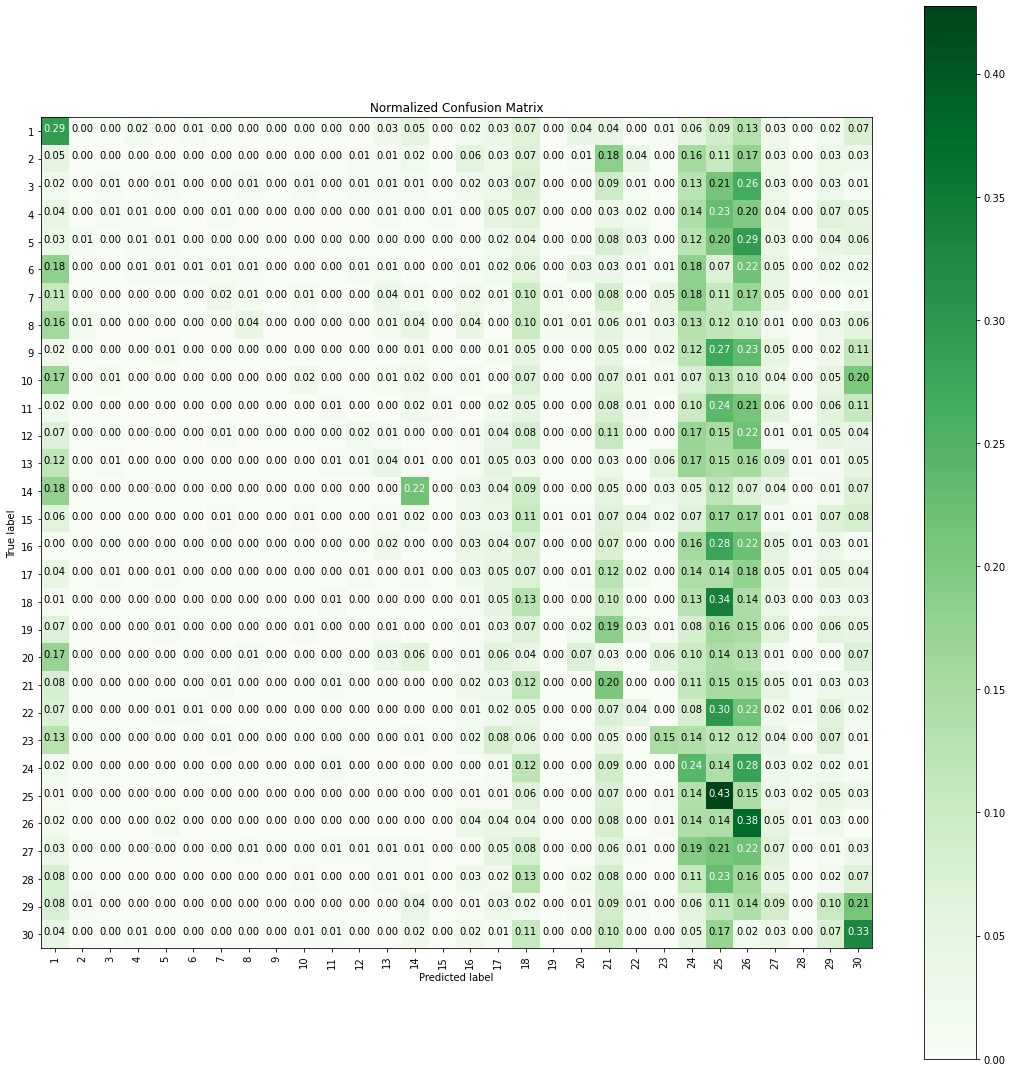


 F1 Score:0.07693132964354987


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.09973911361366856
--------
epsilon:  1.9
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:24:16.683107

Predicting test data
==> testing time:- 0:00:00.532990

==> Accuracy:- 0.10272399081063341


 ********Confusion Matrix********

 [[44  0  0  0  0  0  0  1  0  0  1  1  1  1  0  3  5  6  0  3  5  0  1  6
  11 10  9  0  5  7]
 [ 8  1  0  0  0  0  0  0  0  0  2  0  1  1  0  2  5  3  0  0 17  4  2 15
   7 17  8  3  5  2]
 [ 2  0  0  0  1  0  1  0  0  0  1  0  0  1  1  3  3 13  1  0  7  2  0 16
  18 11  8  0  3  3]
 [ 0  1  0  0  0  0  0  0  1  0  1  0  0  0  1  4  5 10  0  0  

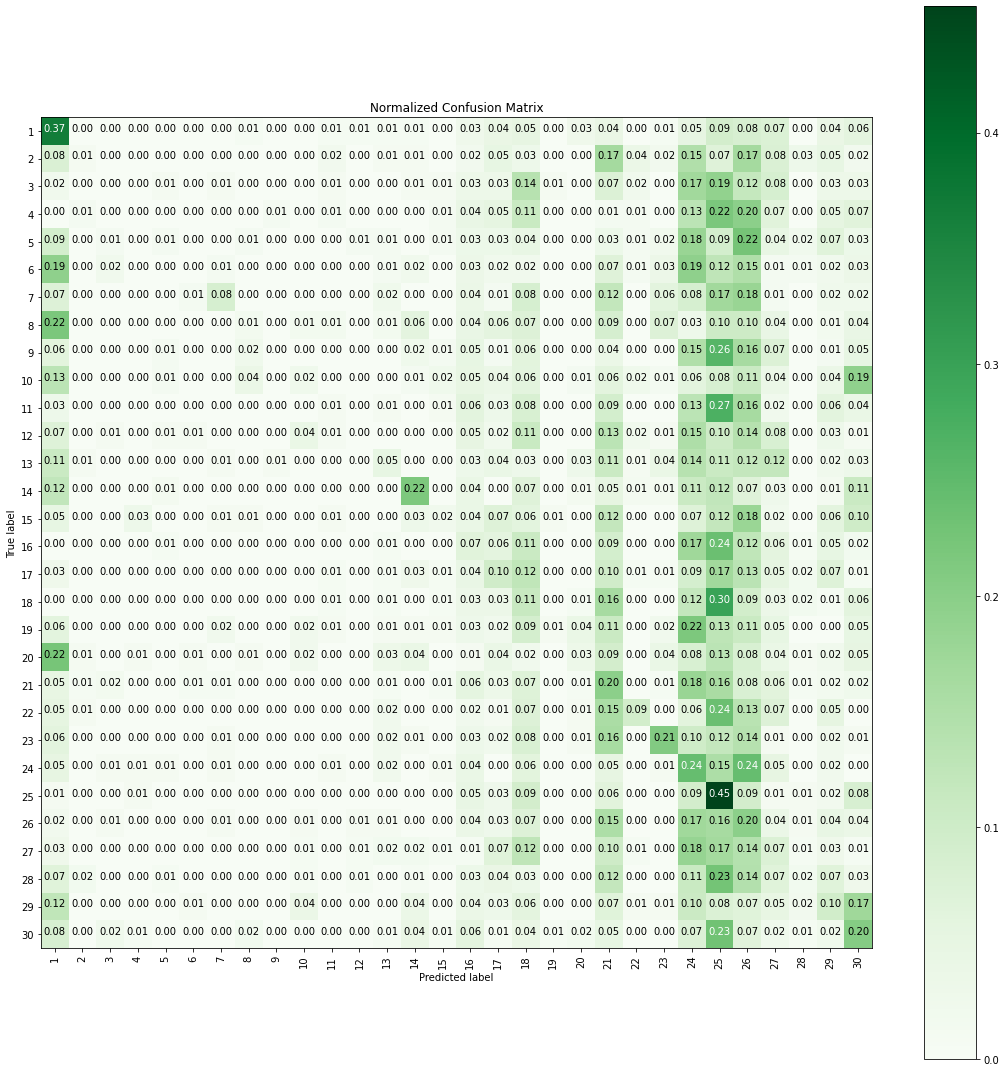


 F1 Score:0.08064797498130757


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.10475424920662306
--------
epsilon:  2.0
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:25:32.751297

Predicting test data
==> testing time:- 0:00:00.402056

==> Accuracy:- 0.11191335740072202


 ********Confusion Matrix********

 [[49  0  1  0  0  0  1  1  0  0  0  0  0  2  0  6  4  5  0  0  2  0  0  9
   9 10  6  0  7  8]
 [ 7  1  0  0  0  0  0  1  0  1  0  0  1  2  2  3  3  7  0  0 10  1  2 14
  10 18 11  0  5  4]
 [ 3  0  1  0  0  0  1  0  0  2  1  1  0  1  1  0  5  8  0  0  6  2  0  9
  20 21  6  0  5  2]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  4  2  2  0  0

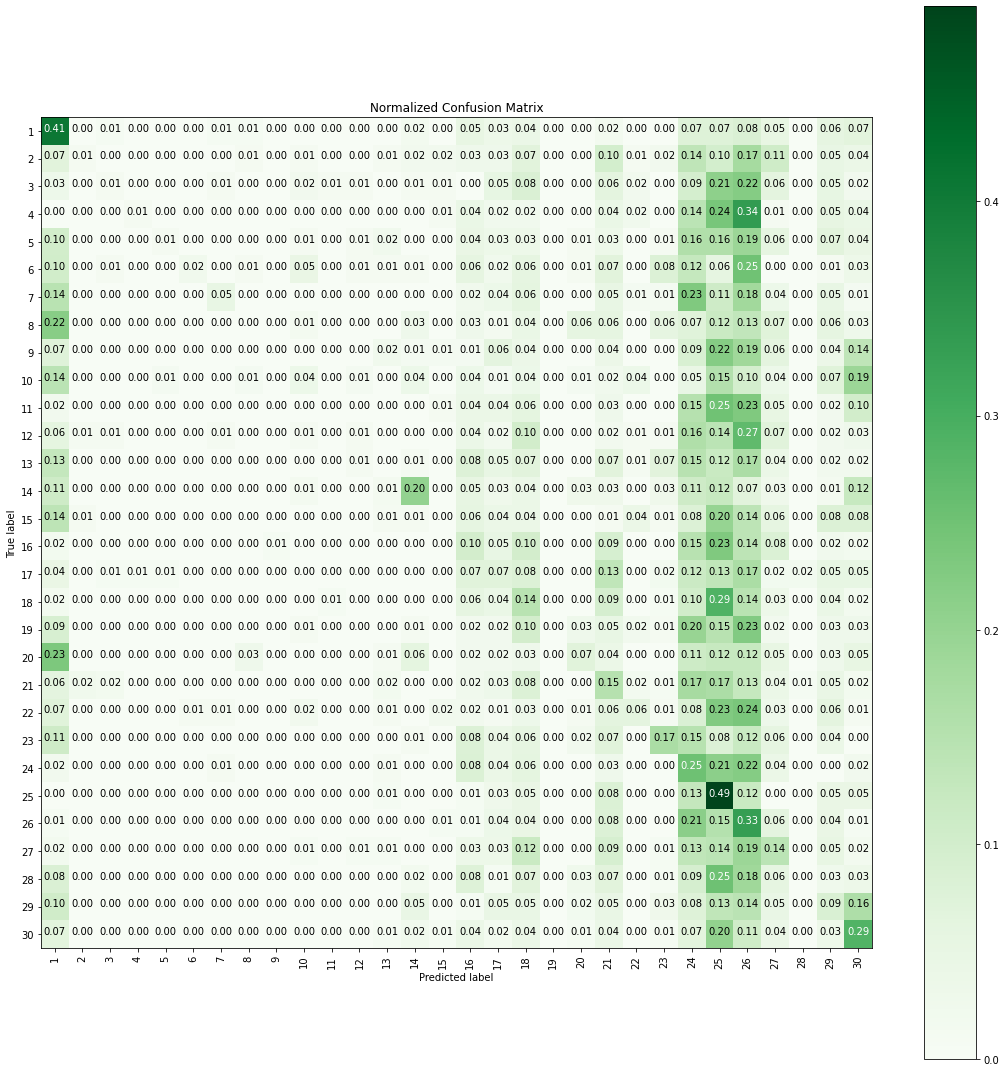


 F1 Score:0.0813215246274867


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.11185752152704802
--------
epsilon:  2.1
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:22:48.875373

Predicting test data
==> testing time:- 0:00:00.420572

==> Accuracy:- 0.11224154906465376


 ********Confusion Matrix********

 [[34  0  0  0  0  0  0  1  1  0  0  0  0 10  0  2  2 10  0  0  3  0  5  5
  12 13  4  0  9  9]
 [ 6  1  0  0  0  1  0  1  0  1  0  0  1  0  1  3  6  3  0  0 16  3  2 13
   7 14  6  1 16  1]
 [ 3  1  0  1  0  1  0  0  0  0  0  0  2  0  1  3  2  6  0  0 12  1  0 16
  24 19  1  0  1  1]
 [ 1  1  0  0  0  0  0  0  0  0  0  0  1  0  0  3  4  4  0  0  3

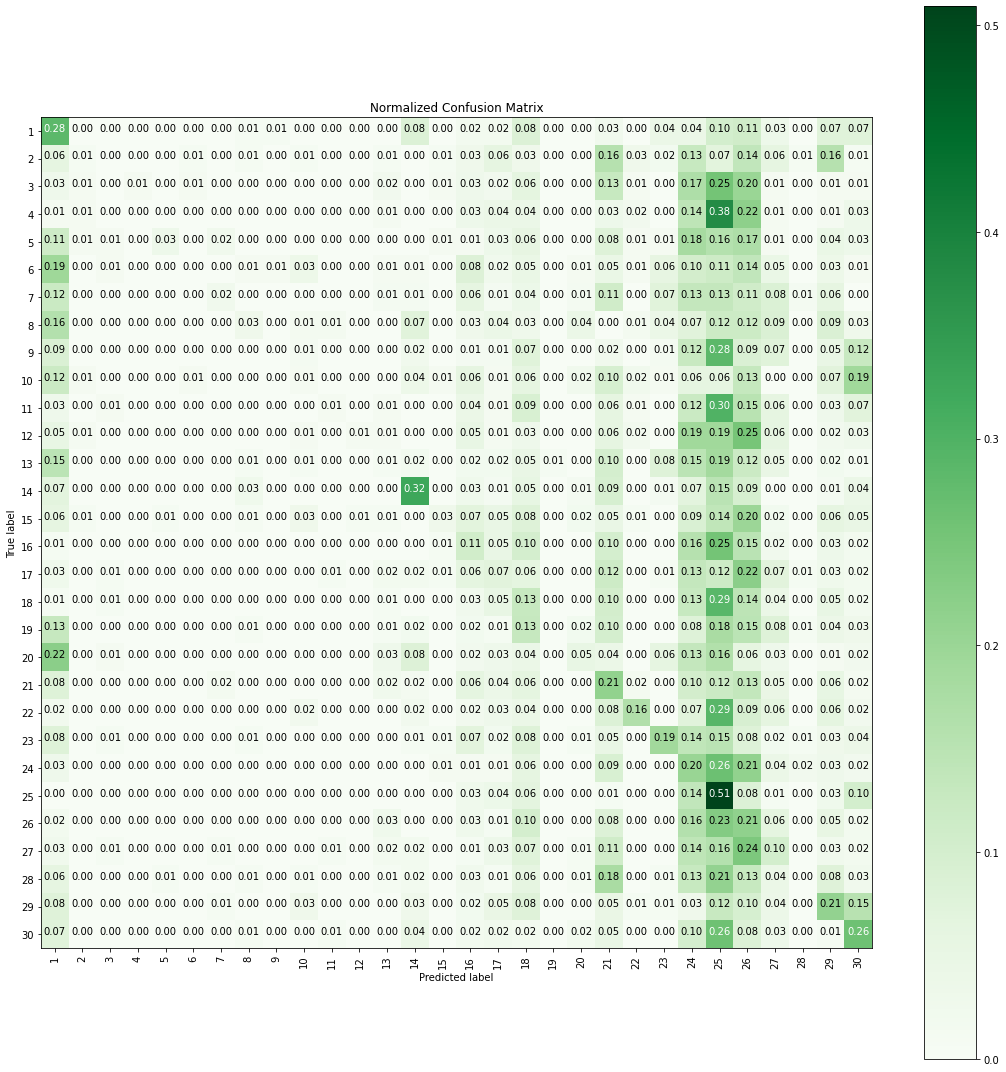


 F1 Score:0.08769699679997604


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.12108056108871704
--------
epsilon:  2.2
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:26:07.352435

Predicting test data
==> testing time:- 0:00:00.350038

==> Accuracy:- 0.130620282244831


 ********Confusion Matrix********

 [[43  0  0  0  0  0  0  1  0  1  1  0  0  1  0  3  3  8  0  1  7  0  3  3
   9 13  9  0  4 10]
 [ 6  2  0  0  0  0  0  0  0  1  0  0  0  1  0  3  2  7  1  0 25  0  1 17
   3 16  8  1  4  5]
 [ 4  0  3  0  0  0  0  0  1  0  0  0  1  1  0  1  7  9  0  0 14  1  0 14
  12 16  6  0  3  2]
 [ 1  1  1  0  0  0  0  0  0  0  0  0  1  0  1  2  0  5  0  0  3 

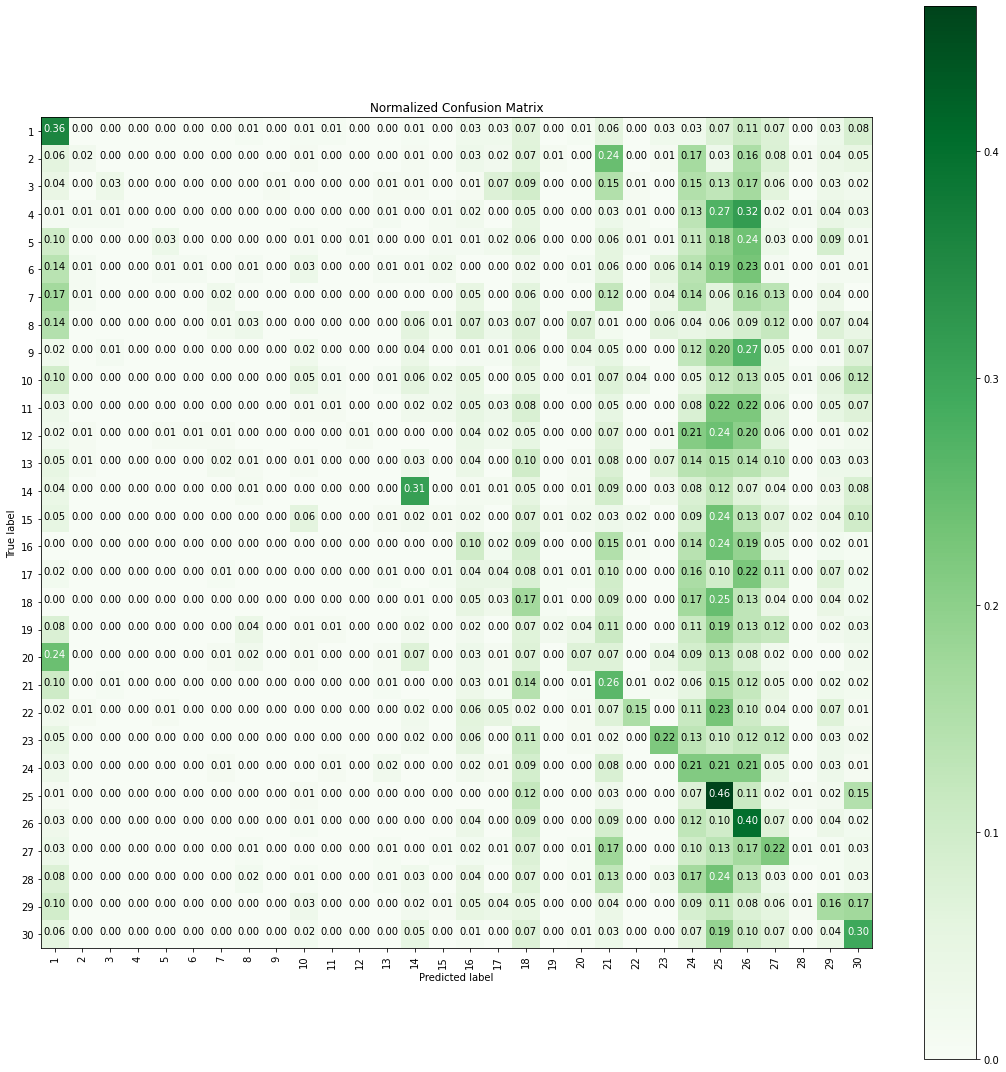


 F1 Score:0.10166415182611668


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.13093882501790652
--------
epsilon:  2.3
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:24:00.055444

Predicting test data
==> testing time:- 0:00:00.282357

==> Accuracy:- 0.12471283229405973


 ********Confusion Matrix********

 [[42  0  0  0  0  1  1  1  0  1  0  0  0  2  0  2  5 12  1  1  9  0  5  8
   9  4  4  0  3  9]
 [ 6  3  0  0  0  0  1  2  0  1  1  0  3  1  0  4  3 10  0  0  7  5  0 15
   8 16  8  3  5  1]
 [ 5  4  4  1  0  0  1  0  0  0  0  2  1  0  0  3  4  9  1  0  7  2  0 14
  15 12  4  0  4  2]
 [ 1  0  1  1  0  0  0  0  1  1  0  0  0  0  0  0  2  5  0  0  

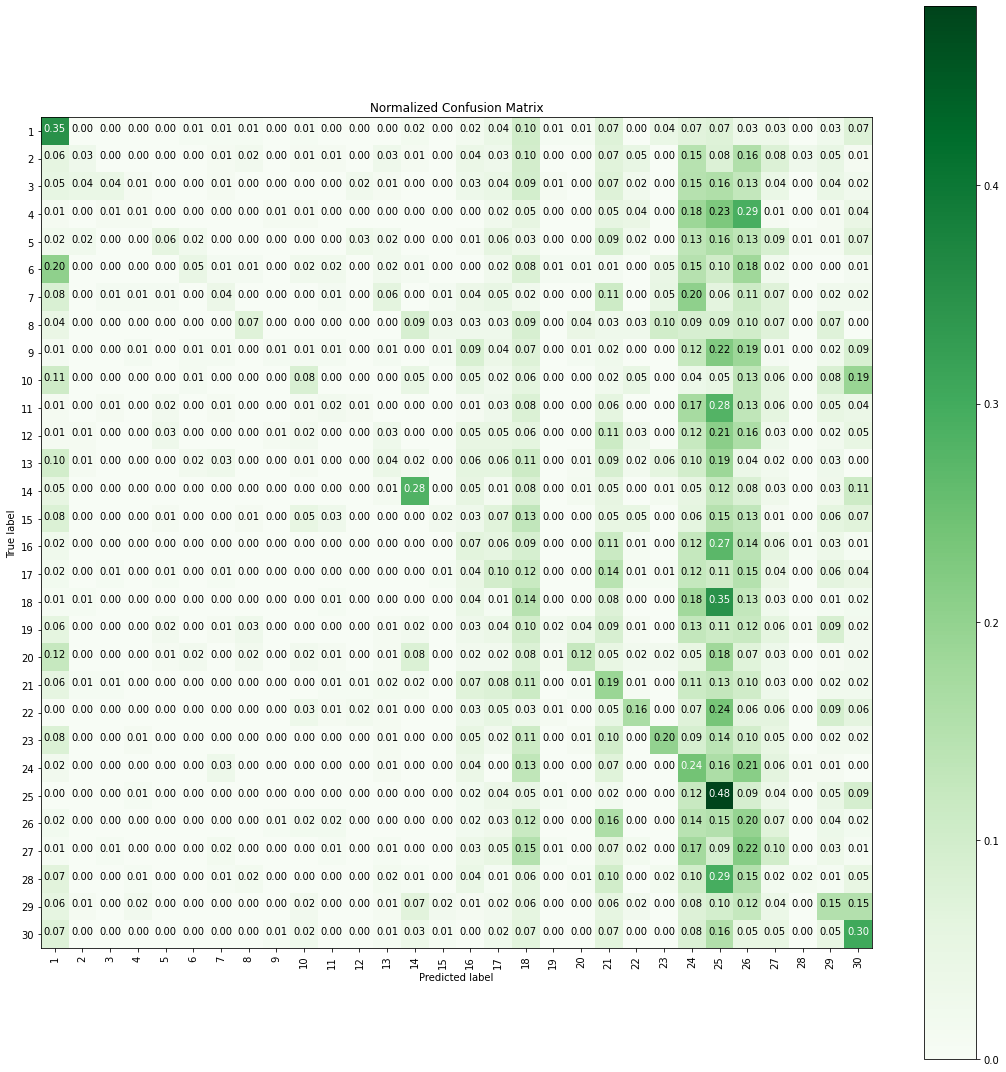


 F1 Score:0.11055002670426486


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.13223253917216932


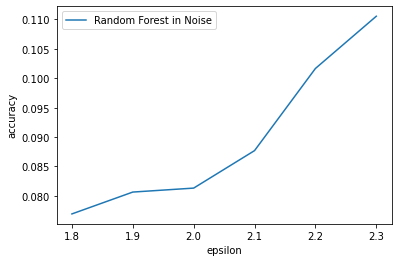

[0.07693132964354987, 0.08064797498130757, 0.0813215246274867, 0.08769699679997604, 0.10166415182611668, 0.11055002670426486]


In [35]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_uid = list()
f1_array_random_uid = list()


# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2, 2.5]
epsilons = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'user_Id')

  # for feature in f_add_weighted_noise:
  #   print(X_train[feature])
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   print(X_train[feature])

  for col in X_train:
      # default sensitivity = 1.0
    if col not in f_add_weighted_noise:
      # print("------epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    else :
      # print("------weighted_epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  
  params = {'n_estimators': np.arange(150,181,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=10, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid,  X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_uid)
  f1_array_random_uid.append(f1)
  acc_array_random_uid.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], f1_array_random_uid[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print(f1_array_random_uid)

## HAR

--------
epsilon:  1.8
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:28:03.890101

Predicting test data
==> testing time:- 0:00:00.478254

==> Accuracy:- 0.7187397440105021


 ********Confusion Matrix********

 [[449  50  40   0   2   0]
 [173 266  48   0   4   1]
 [ 77  48 302   0   1   0]
 [  0   0   0 153 316  37]
 [  0   0   0  50 478   5]
 [  0   0   0   3   2 542]]


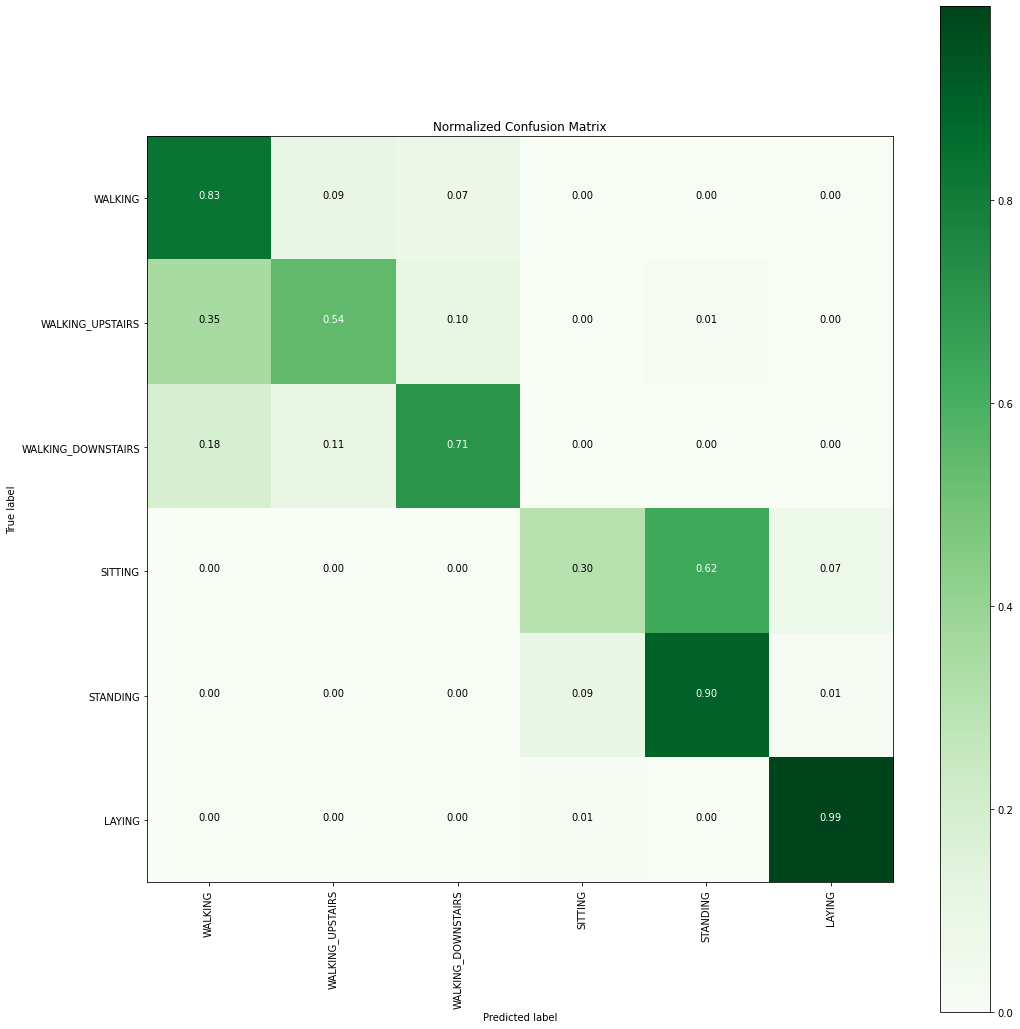


 F1 Score:0.6978360833129269


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7348861040094945
--------
epsilon:  1.9
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:25:19.704065

Predicting test data
==> testing time:- 0:00:01.121908

==> Accuracy:- 0.7397440105021332


 ********Confusion Matrix********

 [[457  42  40   0   2   0]
 [166 273  52   0   1   0]
 [ 71  52 305   0   0   0]
 [  0   0   0 214 262  30]
 [  0   0   0  65 460   8]
 [  0   0   0   2   0 545]]


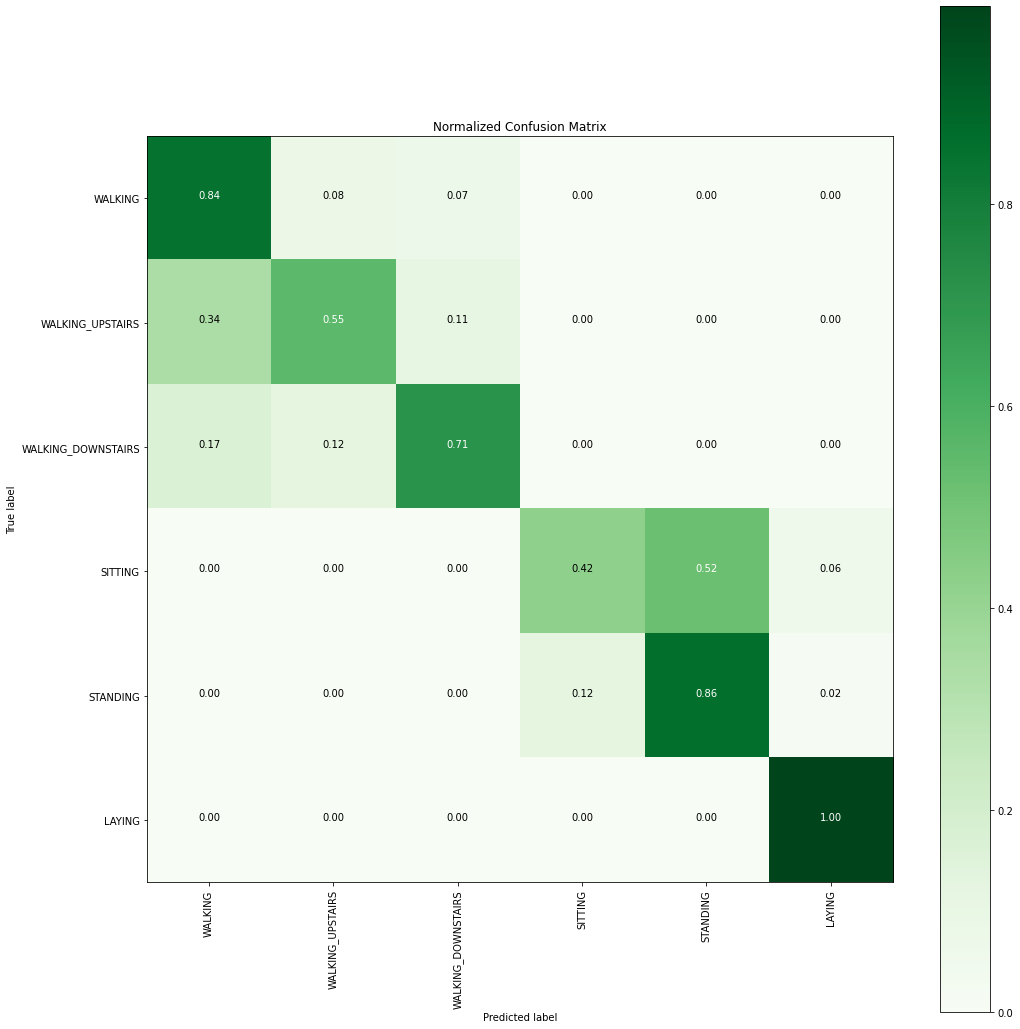


 F1 Score:0.7258094016826271


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7489520104981937
--------
epsilon:  2.0
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:28:03.236645

Predicting test data
==> testing time:- 0:00:00.581770

==> Accuracy:- 0.7509025270758123


 ********Confusion Matrix********

 [[454  50  33   0   4   0]
 [137 303  50   0   2   0]
 [ 78  47 303   0   0   0]
 [  0   0   0 212 262  32]
 [  0   0   0  55 475   3]
 [  0   0   0   5   1 541]]


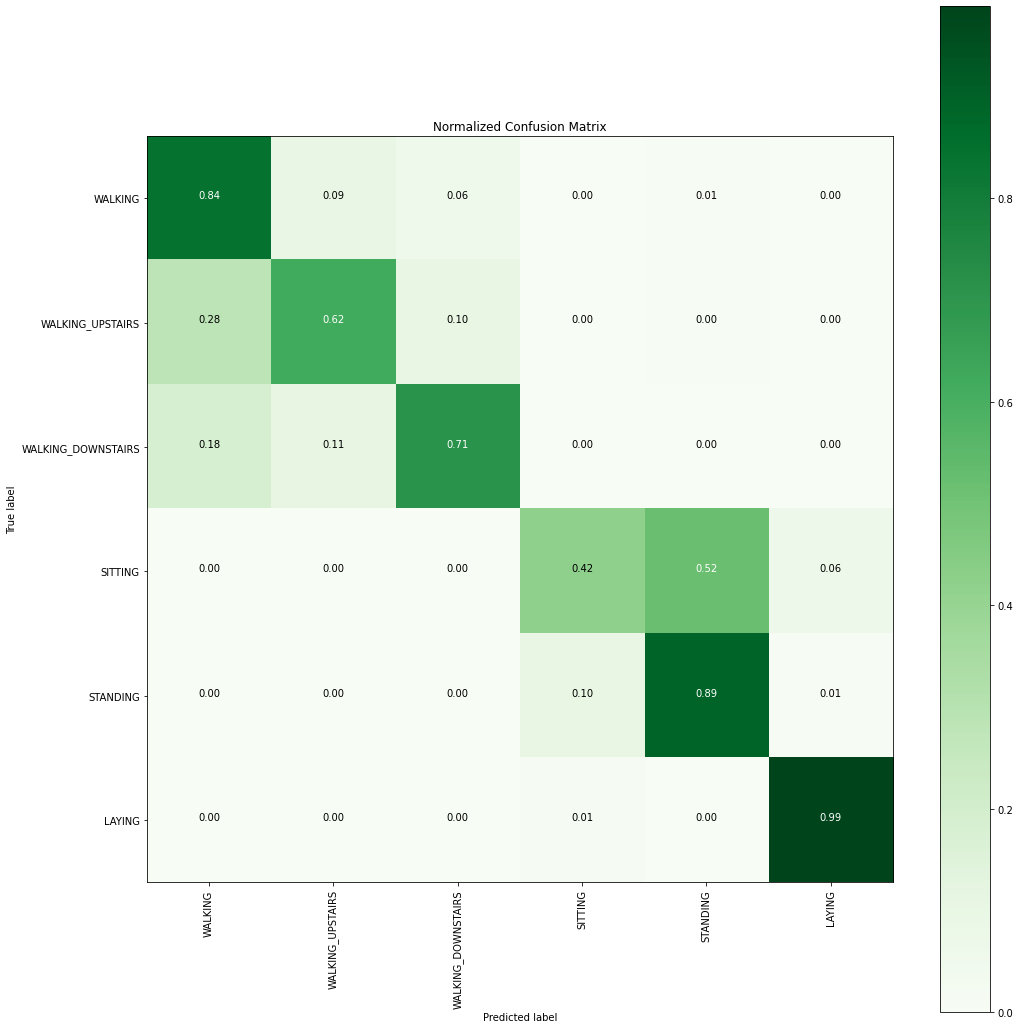


 F1 Score:0.7377776749973982


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.765436474949156
--------
epsilon:  2.1
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:34:16.797828

Predicting test data
==> testing time:- 0:00:00.395545

==> Accuracy:- 0.7623892353134231


 ********Confusion Matrix********

 [[478  33  29   0   1   0]
 [154 297  40   0   1   0]
 [ 82  47 299   0   0   0]
 [  0   0   0 224 262  20]
 [  0   0   0  47 483   3]
 [  0   0   0   5   0 542]]


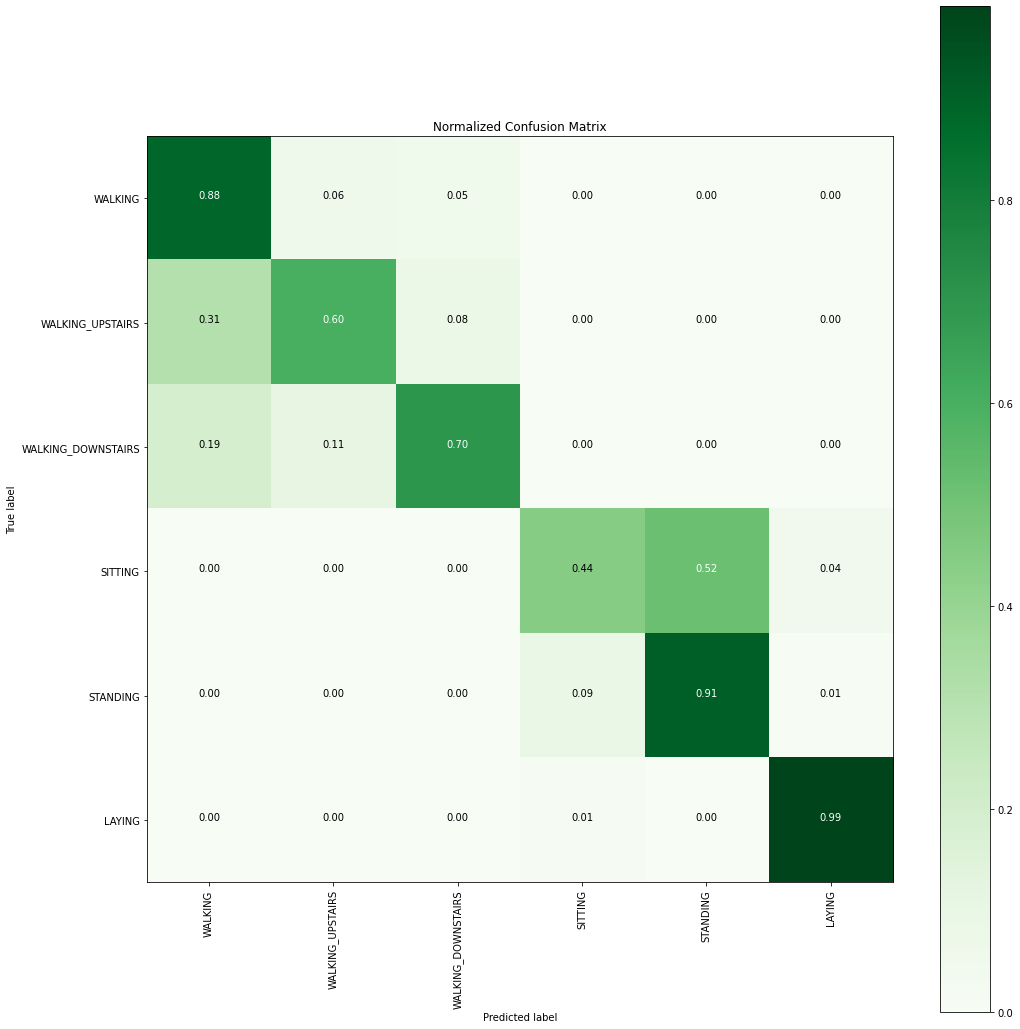


 F1 Score:0.7498252071187753


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7774043111606046
--------
epsilon:  2.2
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:27:35.190637

Predicting test data
==> testing time:- 0:00:01.247593

==> Accuracy:- 0.7705940269117164


 ********Confusion Matrix********

 [[471  38  31   0   1   0]
 [118 325  49   0   0   0]
 [ 76  53 299   0   0   0]
 [  0   0   0 233 251  22]
 [  0   0   0  59 473   1]
 [  0   0   0   0   0 547]]


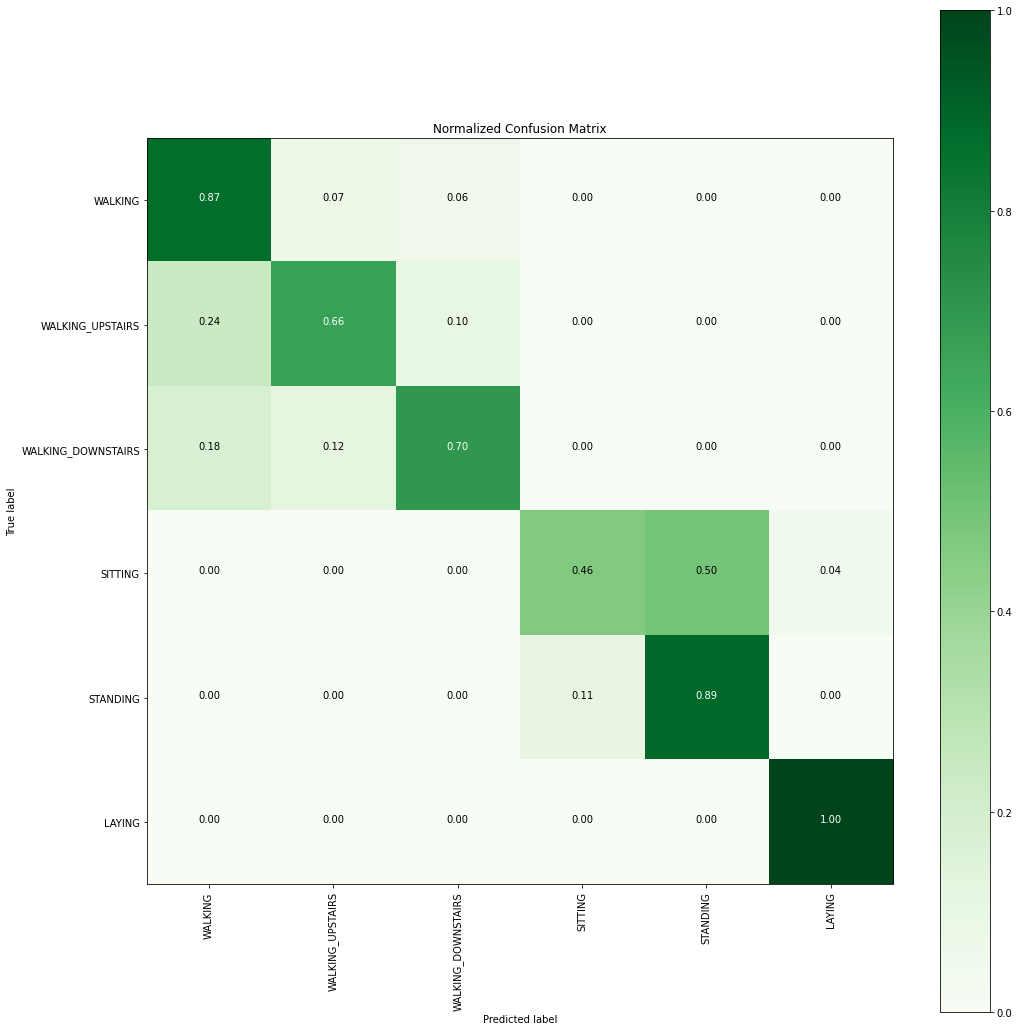


 F1 Score:0.7588876633328271


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7840312959099915
--------
epsilon:  2.3
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:29:17.966507

Predicting test data
==> testing time:- 0:00:00.660730

==> Accuracy:- 0.7768296685264194


 ********Confusion Matrix********

 [[473  33  34   0   1   0]
 [131 319  40   0   2   0]
 [ 72  48 308   0   0   0]
 [  0   0   0 231 254  21]
 [  0   0   0  40 492   1]
 [  0   0   0   2   1 544]]


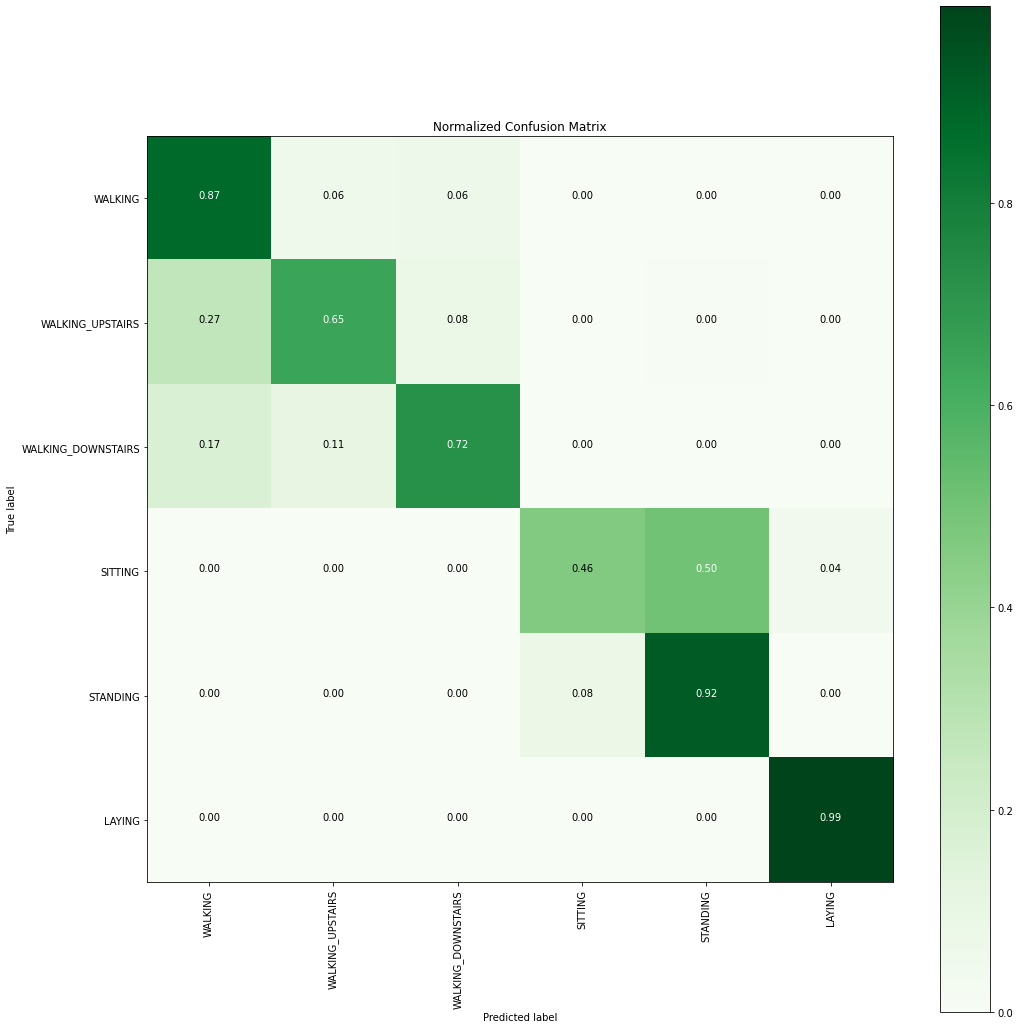


 F1 Score:0.7651034036640705


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7875841084116254


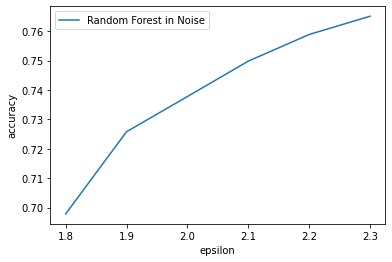

[0.6978360833129269, 0.7258094016826271, 0.7377776749973982, 0.7498252071187753, 0.7588876633328271, 0.7651034036640705]


In [36]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_har = list()
f1_array_random_har = list()


# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2, 2.5]
ctepsilons = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'activity_Id')

  # for feature in f_add_weighted_noise:
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  for col in X_train:
      # default sensitivity = 1.0
    if col not in f_add_weighted_noise:
      # print("------epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    else :
      # print("------weighted_epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

    
  params = {'n_estimators': np.arange(150,201,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=10, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_act)
  f1_array_random_har.append(f1)
  acc_array_random_har.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], f1_array_random_har[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print(f1_array_random_har)

In [37]:
# epsilons = [0.1, 0.3, 0.5, 1.0, 1.2, 1.5, 1.7, 1.8, 2.0]
# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2]
# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2, 2.5]
# epsilons = [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0, 1.2, 1.5]
# epsilons = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3]
print(f1_array_random_har)
print(f1_array_random_uid)
print(acc_array_random_har)
print(acc_array_random_uid)

[0.6978360833129269, 0.7258094016826271, 0.7377776749973982, 0.7498252071187753, 0.7588876633328271, 0.7651034036640705]
[0.07693132964354987, 0.08064797498130757, 0.0813215246274867, 0.08769699679997604, 0.10166415182611668, 0.11055002670426486]
[0.7187397440105021, 0.7397440105021332, 0.7509025270758123, 0.7623892353134231, 0.7705940269117164, 0.7768296685264194]
[0.1043649491302921, 0.10272399081063341, 0.11191335740072202, 0.11224154906465376, 0.130620282244831, 0.12471283229405973]


In [39]:
print(weighted_epsilon)
print(epsilons)

0.001
[1.8, 1.9, 2.0, 2.1, 2.2, 2.3]


In [ ]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()') 

In [ ]:
beep()

ModuleNotFoundError: No module named 'google.colab'